# Preparation

In [1]:
# Add feature to only show outputs
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [1]:
# Activate Packages
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import os

In [2]:
# Set working directory
os.getcwd()
os.chdir("/Users/joelgysel/Austausch/01 Machine Learning/02")

In [3]:
# Implement plot_decision_regions function
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

# Import and merge data 

## Create main data frame

In [4]:
# Import data as panda
children_ratio = pd.read_csv("data/childrenRatio.csv", delimiter=';', skiprows = 0, dtype=None)
election_participation = pd.read_csv("data/electionParticipation.csv", delimiter=';', skiprows = 0, dtype=None)
foreigners = pd.read_csv("data/foreigners.csv", delimiter=';', skiprows = 0, dtype=None)
population_density = pd.read_csv("data/populationDensity.csv", delimiter=';', skiprows = 0, dtype=None)
complete = pd.read_csv("data/complete.csv", delimiter=';', skiprows = 0, dtype=None)
voteshare_al_raw = pd.read_csv("data/voteshare_al_nrw.csv", delimiter=';', skiprows = 0, dtype=None)
voteshare_gp_raw = pd.read_csv("data/voteshare_gp_nrw.csv", delimiter=';', skiprows = 0, dtype=None)
voteshare_sp_raw = pd.read_csv("data/voteshare_sp_nrw.csv", delimiter=';', skiprows = 0, dtype=None)

In [5]:
# Exctract & merge vote data
voteshare_sp = voteshare_sp_raw[voteshare_sp_raw.BFS_NR != 0].iloc[:,[0,1,7,8]]
voteshare_gp = voteshare_gp_raw[voteshare_gp_raw.BFS_NR != 0].iloc[:,[0,7,8]]
voteshare_al = voteshare_al_raw[voteshare_al_raw.BFS_NR != 0].iloc[:,[0,7,8]]

df = pd.merge(voteshare_sp, voteshare_gp, how='outer', on=['BFS_NR','INDIKATOR_JAHR'])
df = pd.merge(df, voteshare_al, how='outer', on=['BFS_NR','INDIKATOR_JAHR'])

# add voteshare 
df['voteshare'] = df.iloc[:,3:6].sum(axis=1, skipna = True)

# add explanatory variables 
df = pd.merge(df, election_participation.iloc[:,[0,7,8]], how='left', on=['BFS_NR','INDIKATOR_JAHR'])
df = pd.merge(df, foreigners.iloc[:,[0,7,8]], how='left', on=['BFS_NR','INDIKATOR_JAHR'])
df = pd.merge(df, population_density.iloc[:,[0,7,8]], how='left', on=['BFS_NR','INDIKATOR_JAHR'])
df = pd.merge(df, children_ratio.iloc[:,[0,7,8]], how='left', on=['BFS_NR','INDIKATOR_JAHR'])

# Rename columns
df.columns = ['BFS_NR', 'GEBIET_NAME', 'INDIKATOR_JAHR','sp','gp','al','voteshare',
              'election_participation','foreigners','population_density','children_ratio']

In [6]:
# add explanatory variables from complete.csv
df = pd.merge(df, complete[complete.INDIKATOR_NAME == 'Altersquotient [%]'].iloc[:,[0,7,8]], how='left', on=['BFS_NR','INDIKATOR_JAHR'])
df = pd.merge(df, complete[complete.INDIKATOR_NAME == 'Bevölkerung: Durchschnittsalter [Jahre]'].iloc[:,[0,7,8]], how='left', on=['BFS_NR','INDIKATOR_JAHR'])
df = pd.merge(df, complete[complete.INDIKATOR_NAME == 'Bevölkerung: übrige/andere/ohne Konfession [Pers.]'].iloc[:,[0,7,8]], how='left', on=['BFS_NR','INDIKATOR_JAHR'])
df = pd.merge(df, complete[complete.INDIKATOR_NAME == 'Durchschnittliche Haushaltsgrösse [Pers.]'].iloc[:,[0,7,8]], how='left', on=['BFS_NR','INDIKATOR_JAHR'])
df = pd.merge(df, complete[complete.INDIKATOR_NAME == 'Sozialhilfequote [%]'].iloc[:,[0,7,8]], how='left', on=['BFS_NR','INDIKATOR_JAHR'])
df = pd.merge(df, complete[complete.INDIKATOR_NAME == 'Arbeitslosenanteil an Bevölkerung 15-64 Jahre [%]'].iloc[:,[0,7,8]], how='left', on=['BFS_NR','INDIKATOR_JAHR'])
df = pd.merge(df, complete[complete.INDIKATOR_NAME == 'Steuerb. Einkommen natürl. Pers. Median [Fr.]'].iloc[:,[0,7,8]], how='left', on=['BFS_NR','INDIKATOR_JAHR'])
df = pd.merge(df, complete[complete.INDIKATOR_NAME == 'Steuerb. Vermögen natürl. Pers. Median [Fr.]'].iloc[:,[0,7,8]], how='left', on=['BFS_NR','INDIKATOR_JAHR'])

# Rename columns
df.columns = ['BFS_NR', 'GEBIET_NAME', 'INDIKATOR_JAHR','sp','gp','al','voteshare',
              'election_participation','foreigners','population_density','children_ratio', 
              "old_ratio", "average_age", "religion", "household_size", 
              "social_aid", "unemployed", "income", "wealth"]



## Deal with missing values and useless data

The columns "sp", "gp" and "al" are deleted because they are no longer needed after we calculated the aggregate party strenght. The columns "average_age", "religion", "social_aid", "household_size" and "unemployed" are deleted because there are either missing values for the election years 2003 to 2015 or because the values are absolute values rather than relative values (e.g. "unemployed") such that they are useless for comparing different comunities with each other. 

The rows for the two comunities "Bauma (bis 2014)" and "Sternenberg (bis 2014)" are deleted because those two communities merged in 2014 s.t. we have no datapoints for 2015

In [7]:
# Delete unnecessary columns & variables 
df = df.drop(columns=["sp", "gp", "al", "average_age", "religion", "social_aid", "household_size", "unemployed"])
del(voteshare_sp, voteshare_sp_raw, voteshare_gp, voteshare_gp_raw, voteshare_al, voteshare_al_raw)
del(children_ratio, election_participation, foreigners, population_density, complete)

In [8]:
# Delete districts "Bauma" and "Sternenberg" due to missing values in 2015
df = df[df.GEBIET_NAME != "Bauma (bis 2014)"]
df = df[df.GEBIET_NAME != "Sternenberg (bis 2014)"]

## Create df for each election year

In [9]:
# create df for each year 
df99 = df[df.INDIKATOR_JAHR == 1999].reset_index(drop=True)
df03 = df[df.INDIKATOR_JAHR == 2003].reset_index(drop=True)
df07 = df[df.INDIKATOR_JAHR == 2007].reset_index(drop=True)
df11 = df[df.INDIKATOR_JAHR == 2011].reset_index(drop=True)
df15 = df[df.INDIKATOR_JAHR == 2015].reset_index(drop=True)

# Add voteshare of last vote
df03 = pd.merge(df03, df99.iloc[:,[0,3]], how='left', on=['BFS_NR'],  suffixes=("", '_past'))
df07 = pd.merge(df07, df03.iloc[:,[0,3]], how='left', on=['BFS_NR'],  suffixes=("", '_past'))
df11 = pd.merge(df11, df07.iloc[:,[0,3]], how='left', on=['BFS_NR'],  suffixes=("", '_past'))
df15 = pd.merge(df15, df11.iloc[:,[0,3]], how='left', on=['BFS_NR'],  suffixes=("", '_past'))

There are three new formed communities in the 2003 dataframe that have not yet existed in 1999. It would be sad to skip the whole 2003-dataframe just because of three missing values. I decided to use the outcome of the 2003 election as the outcome of the 1999 election since this is the best possible approximation. 

In [10]:
# Dealing with missing data in 2003
df03["voteshare_past"] = np.where(np.isnan(df03.voteshare_past), 
                                  df03["voteshare"], 
                                  df03["voteshare_past"])

## Demean the data & plot histogram before and after transformation

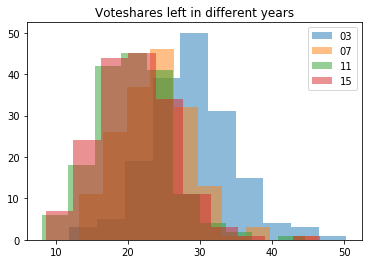

In [11]:
# create histogramm of voteshare
from matplotlib import pyplot
pyplot.hist(df03.voteshare, alpha=0.5, label='03')
pyplot.hist(df07.voteshare, alpha=0.5, label='07')
pyplot.hist(df11.voteshare, alpha=0.5, label='11')
pyplot.hist(df15.voteshare, alpha=0.5, label='15')
pyplot.legend(loc='upper right')
pyplot.title("Voteshares left in different years")
pyplot.show()

In [12]:
# Apply Fligner-Killeen-Test for differences in variance 
scipy.stats.fligner(df03.voteshare, df07.voteshare, df11.voteshare, df15.voteshare)

FlignerResult(statistic=1.9261343222714875, pvalue=0.5878784331994902)

In [13]:
# Demean the data 
df03["voteshare_demeaned"] = df03.voteshare - df03.voteshare.mean()
df07["voteshare_demeaned"] = df07.voteshare - df07.voteshare.mean()
df11["voteshare_demeaned"] = df11.voteshare - df11.voteshare.mean()
df15["voteshare_demeaned"] = df15.voteshare - df15.voteshare.mean()

df03["voteshare_past_demeaned"] = df03.voteshare_past - df03.voteshare_past.mean()
df07["voteshare_past_demeaned"] = df07.voteshare_past - df07.voteshare_past.mean()
df11["voteshare_past_demeaned"] = df11.voteshare_past - df11.voteshare_past.mean()
df15["voteshare_past_demeaned"] = df15.voteshare_past - df15.voteshare_past.mean()

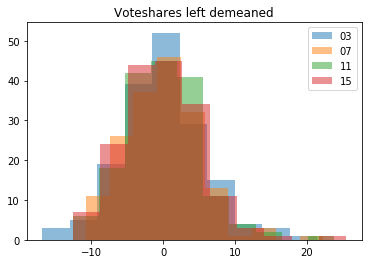

In [14]:
# Plot demeaned data
pyplot.hist(df03.voteshare_demeaned, alpha=0.5, label='03')
pyplot.hist(df07.voteshare_demeaned, alpha=0.5, label='07')
pyplot.hist(df11.voteshare_demeaned, alpha=0.5, label='11')
pyplot.hist(df15.voteshare_demeaned, alpha=0.5, label='15')
pyplot.legend(loc='upper right')
pyplot.title("Voteshares left demeaned")
pyplot.show()

In [15]:
# Add dummy_zero
df03['dummy_zero'] = np.where(df03['voteshare_demeaned']>=0, 1, 0)
df07['dummy_zero'] = np.where(df07['voteshare_demeaned']>=0, 1, 0)
df11['dummy_zero'] = np.where(df11['voteshare_demeaned']>=0, 1, 0)
df15['dummy_zero'] = np.where(df15['voteshare_demeaned']>=0, 1, 0)

## Create X and Y variable for the whole dataset

In [127]:
# Remerge data 
X = [df03, df07, df11, df15]
X = pd.concat(X).reset_index(drop=True)

In [128]:
# Create input and output variables for whole data set
X_multi = X.iloc[:,[4,5,6,7,8,9,10,13]].reset_index(drop = True)
X_select = X.iloc[:,[5,6,10,13]].reset_index(drop = True)
X_uni = X.iloc[:,[13]].reset_index(drop = True)
y_demeaned = X['voteshare_demeaned'].reset_index(drop = True)
y_dummy = X['dummy_zero'].reset_index(drop = True)

# Linear Regression 
## Reg with absolute values
### Fit: last election 

In [18]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
slr = LinearRegression()

In [51]:
# Create X variable
X1 = [df03[['voteshare_past']].reset_index(drop = True), 
      df07[['voteshare_past']].reset_index(drop = True),
      df11[['voteshare_past']].reset_index(drop = True),
      df15[['voteshare_past']].reset_index(drop = True)]

X2 = [X1[0], 
      pd.concat([X1[0],X1[1]]), 
      pd.concat([X1[0],X1[1],X1[2]]), 
      pd.concat([X1[0],X1[1],X1[2],X1[3]])]

In [52]:
# Create y variable 
y1 = [df03[['voteshare']].reset_index(drop = True), 
      df07[['voteshare']].reset_index(drop = True),
      df11[['voteshare']].reset_index(drop = True),
      df15[['voteshare']].reset_index(drop = True)]

y2 = [y1[0], 
      pd.concat([y1[0],y1[1]]), 
      pd.concat([y1[0],y1[1],y1[2]]), 
      pd.concat([y1[0],y1[1],y1[2],y1[3]])]

In [53]:
abs_lastElection = []

for i in range(0,3):
    slr = LinearRegression()
    slr.fit(X1[i], y1[i])
    if i == 0: 
        abs_lastElection.append(r2_score(slr.predict(X1[i]), y1[i]))
        abs_lastElection.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))
    else: 
        abs_lastElection.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))
print(abs_lastElection)

[0.8490118641627782, -1.23759552162472, 0.665720524027138, 0.3828819026926801]


 ### Fit: zero/one

In [22]:
X_self = [df03[['voteshare']].reset_index(drop = True)]
slr.fit(X_self[0], y1[0])

abs_zeroOne = []
for i in range(0,3):
    if i == 0: 
        abs_zeroOne.append(r2_score(slr.predict(X1[i]), y1[i]))
        abs_zeroOne.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))
    else: 
        abs_zeroOne.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))

print(abs_zeroOne)
print(abs_lastElection)

[0.4727748849825517, 0.15099588365864058, 0.43017378715707777, 0.9091255182006651]
[0.8490118641627782, -1.23759552162472, 0.665720524027138, 0.3828819026926801]


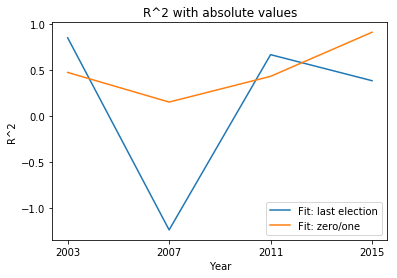

In [23]:
# Create graph with r^2
plot = pd.DataFrame({"Fit: last election" : abs_lastElection,
                    "Fit: zero/one" : abs_zeroOne}, 
                    index = [2003, 2007, 2011, 2015])
plot.plot(xticks = plot.index)
plt.title("R^2 with absolute values")
plt.xlabel("Year")
plt.ylabel("R^2")
plt.show()

## Reg with relative values

### Fit: zero/one

In [24]:
# Create X variable
X_self = [df03[['voteshare_demeaned']].reset_index(drop = True)] 

X1 = [df03[['voteshare_past_demeaned']].reset_index(drop = True), 
      df07[['voteshare_past_demeaned']].reset_index(drop = True),
      df11[['voteshare_past_demeaned']].reset_index(drop = True),
      df15[['voteshare_past_demeaned']].reset_index(drop = True)]

X2 = [X1[0], 
      pd.concat([X1[0],X1[1]]), 
      pd.concat([X1[0],X1[1],X1[2]]), 
      pd.concat([X1[0],X1[1],X1[2],X1[3]])]

In [25]:
# Create y variable 
y1 = [df03[['voteshare_demeaned']].reset_index(drop = True), 
      df07[['voteshare_demeaned']].reset_index(drop = True),
      df11[['voteshare_demeaned']].reset_index(drop = True),
      df15[['voteshare_demeaned']].reset_index(drop = True)]

y2 = [y1[0], 
      pd.concat([y1[0],y1[1]]), 
      pd.concat([y1[0],y1[1],y1[2]]), 
      pd.concat([y1[0],y1[1],y1[2],y1[3]])]

In [26]:
slr.fit(X_self[0], y1[0])

relative_zeroOne = []
for i in range(0,3):
    if i == 0: 
        relative_zeroOne.append(r2_score(slr.predict(X1[i]), y1[i]))
        relative_zeroOne.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))
    else: 
        relative_zeroOne.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))

### Fit: last election 

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

relative_lastElection = []
for i in range(0,3):
    slr = LinearRegression()
    slr.fit(X1[i], y1[i])
    if i == 0: 
        relative_lastElection.append(r2_score(slr.predict(X1[i]), y1[i]))
        relative_lastElection.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))

    else: 
        relative_lastElection.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))


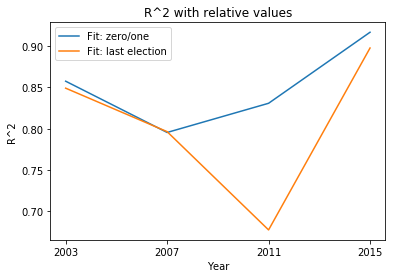

In [28]:
# Create graph with r^2
plot = pd.DataFrame({"Fit: zero/one" : relative_zeroOne,
                    "Fit: last election" : relative_lastElection}, 
                    index = [2003, 2007, 2011, 2015])
plot.plot(xticks = plot.index)
plt.title("R^2 with relative values")
plt.xlabel("Year")
plt.ylabel("R^2")
plt.show()

### Fit: last elections 

In [31]:
relative_lastElections = []
predicted_values = []

for i in range(0,3):
    slr = LinearRegression()
    slr.fit(X2[i], y2[i])
    if i == 0: 
        relative_lastElections.append(r2_score(slr.predict(X1[i]), y1[i]))
        relative_lastElections.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))
        predicted_values.append(slr.predict(X1[i]))
        predicted_values.append(slr.predict(X1[i+1]))
    else: 
        relative_lastElections.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))
        predicted_values.append(slr.predict(X1[i+1]))

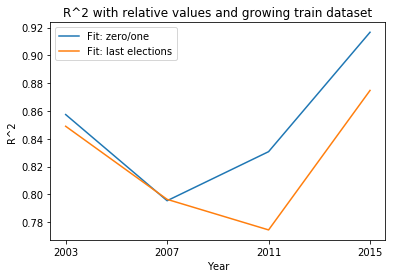

In [32]:
# Create graph with r^2
plot = pd.DataFrame({"Fit: zero/one" : relative_zeroOne,
                    "Fit: last elections" : relative_lastElections}, 
                    index = [2003, 2007, 2011, 2015])
plot.plot(xticks = plot.index)
plt.title("R^2 with relative values and growing train dataset")
plt.xlabel("Year")
plt.ylabel("R^2")
plt.show()

## Test relative multivariate models 
### Fit: zero/one 

In [33]:
# Create x variable
X_self = [df03.iloc[:,[4,5,6,7,8,9,10,13]]] 

X1 = [df03.iloc[:,[4,5,6,7,8,9,10,13]],
      df07.iloc[:,[4,5,6,7,8,9,10,13]],
      df11.iloc[:,[4,5,6,7,8,9,10,13]],
      df15.iloc[:,[4,5,6,7,8,9,10,13]]]

In [34]:
X2 = [X1[0], 
      pd.concat([X1[0],X1[1]]), 
      pd.concat([X1[0],X1[1],X1[2]]), 
      pd.concat([X1[0],X1[1],X1[2],X1[3]])]

In [35]:
# Create y variable 
y1 = [df03[['voteshare_demeaned']].reset_index(drop = True), 
      df07[['voteshare_demeaned']].reset_index(drop = True),
      df11[['voteshare_demeaned']].reset_index(drop = True),
      df15[['voteshare_demeaned']].reset_index(drop = True)]

y2 = [y1[0], 
      pd.concat([y1[0],y1[1]]), 
      pd.concat([y1[0],y1[1],y1[2]]), 
      pd.concat([y1[0],y1[1],y1[2],y1[3]])]

In [36]:
slr.fit(X_self[0], y1[0])
relative_multivariate_zeroOne = []

for i in range(0,3):
    if i == 0: 
        relative_multivariate_zeroOne.append(r2_score(slr.predict(X1[i]), y1[i]))
        relative_multivariate_zeroOne.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))
    else: 
        relative_multivariate_zeroOne.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))

### Fit: last election 

In [37]:
relative_multivariate_lastElection = []

for i in range(0,3):
    slr = LinearRegression()
    slr.fit(X1[i], y1[i])
    if i == 0: 
        relative_multivariate_lastElection.append(r2_score(slr.predict(X1[i]), y1[i]))
        relative_multivariate_lastElection.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))

    else: 
        relative_multivariate_lastElection.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))

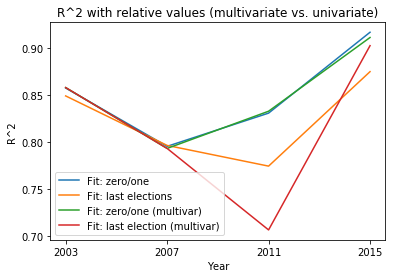

In [38]:
# Create graph with r^2
plot = pd.DataFrame({"Fit: zero/one" : relative_zeroOne,
                    "Fit: last elections" : relative_lastElections, 
                    "Fit: zero/one (multivar)": relative_multivariate_zeroOne,
                    "Fit: last election (multivar)": relative_multivariate_lastElection},  
                    index = [2003, 2007, 2011, 2015])
plot.plot(xticks = plot.index)
plt.title("R^2 with relative values (multivariate vs. univariate)")
plt.xlabel("Year")
plt.ylabel("R^2")
plt.show()

## Feature selection 

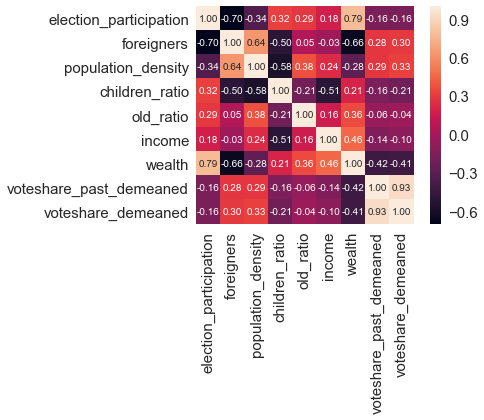

In [402]:
import numpy as np
import seaborn as sns

coef = df03.iloc[:,[4,5,6,7,8,9,10,13,12]]
cm = np.corrcoef(coef.values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=list(coef), 
                 xticklabels=list(coef))
plt.show()

Exclude from regression: election_participation, children_ratio, old_ratio, income

## New regressions with less features
### Fit: zero/one

In [39]:
# Create x variable
X_self = [df03.iloc[:,[5,6,10,13]]] 

X1 = [df03.iloc[:,[5,6,10,13]],
      df07.iloc[:,[5,6,10,13]],
      df11.iloc[:,[5,6,10,13]],
      df15.iloc[:,[5,6,10,13]]]

X2 = [X1[0], 
      pd.concat([X1[0],X1[1]]), 
      pd.concat([X1[0],X1[1],X1[2]]), 
      pd.concat([X1[0],X1[1],X1[2],X1[3]])]

In [40]:
# Create y variable 
y1 = [df03[['voteshare_demeaned']].reset_index(drop = True), 
      df07[['voteshare_demeaned']].reset_index(drop = True),
      df11[['voteshare_demeaned']].reset_index(drop = True),
      df15[['voteshare_demeaned']].reset_index(drop = True)]

y2 = [y1[0], 
      pd.concat([y1[0],y1[1]]), 
      pd.concat([y1[0],y1[1],y1[2]]), 
      pd.concat([y1[0],y1[1],y1[2],y1[3]])]

In [41]:
slr.fit(X_self[0], y1[0])
relative_selected_zeroOne = []

for i in range(0,3):
    if i == 0: 
        relative_selected_zeroOne.append(r2_score(slr.predict(X1[i]), y1[i]))
        relative_selected_zeroOne.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))
    else: 
        relative_selected_zeroOne.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))

In [42]:
relative_selected_lastElection = []

for i in range(0,3):
    slr = LinearRegression()
    slr.fit(X1[i], y1[i])
    if i == 0: 
        relative_selected_lastElection.append(r2_score(slr.predict(X1[i]), y1[i]))
        relative_selected_lastElection.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))

    else: 
        relative_selected_lastElection.append(r2_score(slr.predict(X1[i+1]), y1[i+1]))

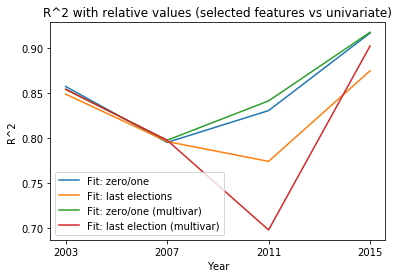

In [43]:
# Create graph with r^2
plot = pd.DataFrame({"Fit: zero/one" : relative_zeroOne,
                    "Fit: last elections" : relative_lastElections, 
                    "Fit: zero/one (multivar)": relative_selected_zeroOne,
                    "Fit: last election (multivar)": relative_selected_lastElection},  
                    index = [2003, 2007, 2011, 2015])
plot.plot(xticks = plot.index)
plt.title("R^2 with relative values (selected features vs univariate)")
plt.xlabel("Year")
plt.ylabel("R^2")
plt.show()

## Transform back to absolute values

In [46]:
# Test absolute value accuracy for 2007  
test = pd.DataFrame(predicted_values[1])
test["abs"] = test + df03.voteshare.mean() - 1.9
X = test[["abs"]] 
y = df07[["voteshare"]]
print(r2_score(X, y))

0.544364492998791


In [48]:
# Test absolute value accuracy for 2011
test = pd.DataFrame(predicted_values[2])
test["abs"] = test + df07.voteshare.mean() - 0.8
X = test[["abs"]] 
y = df11[["voteshare"]]
print(r2_score(X, y))

0.46865495446115146


In [50]:
# Test absolute value accuracy for 2015
test = pd.DataFrame(predicted_values[3])
test["abs"] = test + df11.voteshare.mean() + 1.1
X = test[["abs"]] 
y = df15[["voteshare"]]
print(r2_score(X, y))

0.8553654540654029


# Decision tree regression

### Visualize decision tree regression 

In [55]:
from sklearn.tree import DecisionTreeRegressor
import numpy 

In [56]:
# define lin_regplot
def lin_regplot(X, y, model): 
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

0.8744748734377927


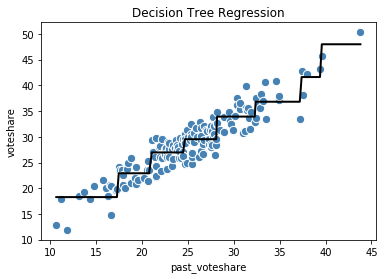

In [78]:
X = df03[["voteshare_past"]].values
y = df03[["voteshare"]].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
score = tree.score(X, y)
print(score)

sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.title("Decision Tree Regression")
plt.xlabel('past_voteshare')
plt.ylabel('voteshare')
plt.show()

### Test decision tree regression 

In [79]:
# Create X variable
X = [df03[['voteshare_past_demeaned']].reset_index(drop = True), 
      df07[['voteshare_past_demeaned']].reset_index(drop = True),
      df11[['voteshare_past_demeaned']].reset_index(drop = True),
      df15[['voteshare_past_demeaned']].reset_index(drop = True)]

# Create y variable 
y = [df03[['voteshare_demeaned']].reset_index(drop = True), 
      df07[['voteshare_demeaned']].reset_index(drop = True),
      df11[['voteshare_demeaned']].reset_index(drop = True),
      df15[['voteshare_demeaned']].reset_index(drop = True)]

In [82]:
# Testing
decision_tree = []
for i in range(0,3):
    tree = DecisionTreeRegressor(max_depth=3)
    tree.fit(X[i].values, y[i].values)
    if i == 0: 
        decision_tree.append(tree.score(X[i].values, y[i].values))
        decision_tree.append(tree.score(X[i+1].values, y[i+1].values))
    else: 
        decision_tree.append(tree.score(X[i+1].values, y[i+1].values))
decision_tree

[0.8744748734377927, 0.680620947737856, 0.7929435908867237, 0.8765172064962299]

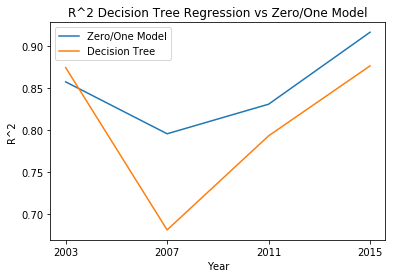

In [83]:
# Plot results
plot = pd.DataFrame({"Zero/One Model" : relative_zeroOne,
                    "Decision Tree" : decision_tree}, 
                    index = [2003, 2007, 2011, 2015])
plot.plot(xticks = plot.index)
plt.title("R^2 Decision Tree Regression vs Zero/One Model")
plt.xlabel("Year")
plt.ylabel("R^2")
plt.show()

# Classification
## Logistic Regression 
### Plot logistic regression with two features

Accuracy: 0.86


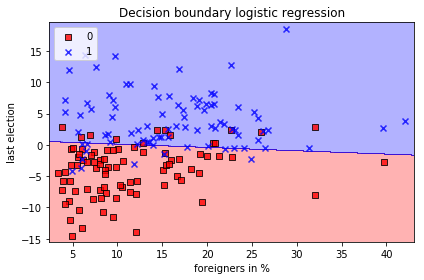

In [99]:
# Run logistic regression on dummy_zero
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define two-dimensional X-variable
X = df03.iloc[:,[5,13]].values
y = df03["dummy_zero"].reset_index(drop = True)
lr = LogisticRegression(random_state=1)
lr.fit(X, y)

print('Accuracy: %.2f' % accuracy_score(y, lr.predict(X)))


# Plot decision boundarys 
# test_idx=range(105, 150))
plot_decision_regions(np.array(X), 
                      np.array(y),
                      classifier=lr)
plt.xlabel('foreigners in %')
plt.ylabel('last election')
plt.legend(loc='upper left')
plt.title("Decision boundary logistic regression")
plt.tight_layout()
plt.show()

### Test accuracy of univariate and multivariate model

#### Accuracy of univariate model

In [100]:
# Create x variable
X1 = [df03.iloc[:,[13]],
      df07.iloc[:,[13]],
      df11.iloc[:,[13]],
      df15.iloc[:,[13]]]

X2 = [X1[0], 
      pd.concat([X1[0],X1[1]]), 
      pd.concat([X1[0],X1[1],X1[2]]), 
      pd.concat([X1[0],X1[1],X1[2],X1[3]])]

# Create y variable 
y1 = [df03[['dummy_zero']].reset_index(drop = True), 
      df07[['dummy_zero']].reset_index(drop = True),
      df11[['dummy_zero']].reset_index(drop = True),
      df15[['dummy_zero']].reset_index(drop = True)]

y2 = [y1[0], 
      pd.concat([y1[0],y1[1]]), 
      pd.concat([y1[0],y1[1],y1[2]]), 
      pd.concat([y1[0],y1[1],y1[2],y1[3]])]

In [102]:
# Accuracy univariate
a = []
for i in range(0,3):
    lr = LogisticRegression(random_state=1)  
    lr.fit(X1[i], y1[i])
    if i == 0: 
        a.append(accuracy_score(y1[i], lr.predict(X1[i]), normalize=True))
        a.append(accuracy_score(y1[i+1], lr.predict(X1[i+1]), normalize=True))
    else: 
        a.append(accuracy_score(y1[i+1], lr.predict(X1[i+1]), normalize=True))

b = []
for i in range(0,3):
    lr = LogisticRegression(random_state=1)  
    lr.fit(X2[i], y2[i])
    if i == 0: 
        b.append(accuracy_score(y2[i], lr.predict(X2[i]), normalize=True))
        b.append(accuracy_score(y2[i+1], lr.predict(X2[i+1]), normalize=True))
    else: 
        b.append(accuracy_score(y2[i+1], lr.predict(X2[i+1]), normalize=True))

/Users/joelgysel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Accuracy of multivariate model

In [103]:
# Create x variable
X1 = [df03.iloc[:,[4,5,6,7,8,9,10,13]],
      df07.iloc[:,[4,5,6,7,8,9,10,13]],
      df11.iloc[:,[4,5,6,7,8,9,10,13]],
      df15.iloc[:,[4,5,6,7,8,9,10,13]]]

X2 = [X1[0], 
      pd.concat([X1[0],X1[1]]), 
      pd.concat([X1[0],X1[1],X1[2]]), 
      pd.concat([X1[0],X1[1],X1[2],X1[3]])]

# Create y variable 
y1 = [df03[['dummy_zero']].reset_index(drop = True), 
      df07[['dummy_zero']].reset_index(drop = True),
      df11[['dummy_zero']].reset_index(drop = True),
      df15[['dummy_zero']].reset_index(drop = True)]

y2 = [y1[0], 
      pd.concat([y1[0],y1[1]]), 
      pd.concat([y1[0],y1[1],y1[2]]), 
      pd.concat([y1[0],y1[1],y1[2],y1[3]])]

In [104]:
# Accuracy multivariate
c = []
for i in range(0,3):
    lr = LogisticRegression(random_state=1)  
    lr.fit(X1[i], y1[i])
    if i == 0: 
        c.append(accuracy_score(y1[i], lr.predict(X1[i]), normalize=True))
        c.append(accuracy_score(y1[i+1], lr.predict(X1[i+1]), normalize=True))
    else: 
        c.append(accuracy_score(y1[i+1], lr.predict(X1[i+1]), normalize=True))

d = []
for i in range(0,3):
    lr = LogisticRegression(random_state=1)  
    lr.fit(X2[i], y2[i])
    if i == 0: 
        d.append(accuracy_score(y2[i], lr.predict(X2[i]), normalize=True))
        d.append(accuracy_score(y2[i+1], lr.predict(X2[i+1]), normalize=True))
    else: 
        d.append(accuracy_score(y2[i+1], lr.predict(X2[i+1]), normalize=True))

/Users/joelgysel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


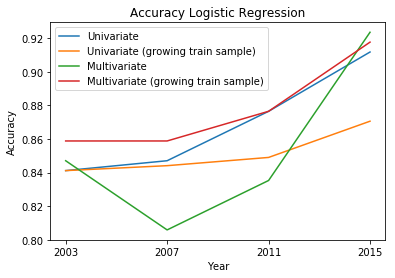

In [138]:
# Create accuracy plot
plot = pd.DataFrame({"Univariate" : a,
                     "Univariate (growing train sample)" : b,
                     "Multivariate" : c,
                     "Multivariate (growing train sample)" : d},
                    index = [2003, 2007, 2011, 2015])
plot.plot(xticks = plot.index)
plt.title("Accuracy Logistic Regression")
plt.xlabel("Year")
plt.ylabel("Accuracy")
plt.show()

#### Accuracy of multivariate model with selected features

In [121]:
# Create x variable
X1 = [df03.iloc[:,[5,13]],
      df07.iloc[:,[5,13]],
      df11.iloc[:,[5,13]],
      df15.iloc[:,[5,13]]]

# Create y variable 
y1 = [df03[['dummy_zero']].reset_index(drop = True), 
      df07[['dummy_zero']].reset_index(drop = True),
      df11[['dummy_zero']].reset_index(drop = True),
      df15[['dummy_zero']].reset_index(drop = True)]

# Accuracy select (foreigners)
e = []
for i in range(0,3):
    lr = LogisticRegression(random_state=1)  
    lr.fit(X1[i], y1[i])
    if i == 0: 
        e.append(accuracy_score(y1[i], lr.predict(X1[i]), normalize=True))
        e.append(accuracy_score(y1[i+1], lr.predict(X1[i+1]), normalize=True))
    else: 
        e.append(accuracy_score(y1[i+1], lr.predict(X1[i+1]), normalize=True))

/Users/joelgysel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [122]:
# Create x variable
X1 = [df03.iloc[:,[5,6,10,13]],
      df07.iloc[:,[5,6,10,13]],
      df11.iloc[:,[5,6,10,13]],
      df15.iloc[:,[5,6,10,13]]]

# Create y variable 
y1 = [df03[['dummy_zero']].reset_index(drop = True), 
      df07[['dummy_zero']].reset_index(drop = True),
      df11[['dummy_zero']].reset_index(drop = True),
      df15[['dummy_zero']].reset_index(drop = True)]

# Accuracy select (foreigners)
f = []
for i in range(0,3):
    lr = LogisticRegression(random_state=1)  
    lr.fit(X1[i], y1[i])
    if i == 0: 
        f.append(accuracy_score(y1[i], lr.predict(X1[i]), normalize=True))
        f.append(accuracy_score(y1[i+1], lr.predict(X1[i+1]), normalize=True))
    else: 
        f.append(accuracy_score(y1[i+1], lr.predict(X1[i+1]), normalize=True))

/Users/joelgysel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


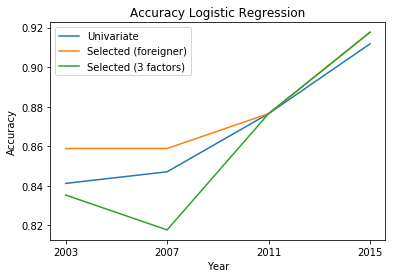

In [137]:
# Create accuracy plot
plot = pd.DataFrame({"Univariate" : a,
                     "Selected (foreigner)" : e,
                     "Selected (3 factors)" : f}, 
                    index = [2003, 2007, 2011, 2015])
plot.plot(xticks = plot.index)
plt.title("Accuracy Logistic Regression")
plt.xlabel("Year")
plt.ylabel("Accuracy")
plt.show()

## Decision Tree

In [125]:
# load relevant packages
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import graphviz 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### Looking for the optimal depth of the decision tree

85.44117647058825
85.44117647058825
84.70588235294117
84.55882352941175
83.9705882352941
83.38235294117646
83.23529411764706
82.64705882352942
82.35294117647058
82.64705882352942
83.52941176470588
83.52941176470588
83.82352941176471
83.9705882352941
83.9705882352941
83.82352941176471
84.11764705882354


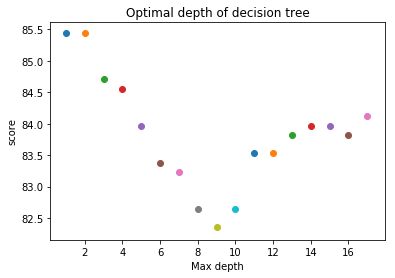

In [131]:
# searching for the depth of the tree that returns the best model accuracy
seed=123

for i in range(1,18):
    tree = DecisionTreeClassifier(criterion='gini',max_depth=i ,random_state=1)  
    tree.fit(X_uni, y_dummy) 
    y_pred = tree.predict(X_uni)
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    score = cross_val_score(tree, X_uni, y_dummy, cv=kfold)
    mean = score.mean()*100
    plt.scatter(i, mean)
    plt.title("Optimal depth of decision tree")
    plt.xlabel("Max depth")
    plt.ylabel("score")
    print(mean)
plt.show()

### Test accuracy of decision tree

In [149]:
# Create x variable
X1 = [df03.iloc[:,[13]],
      df07.iloc[:,[13]],
      df11.iloc[:,[13]],
      df15.iloc[:,[13]]]

# Create y variable 
y1 = [df03[['dummy_zero']].reset_index(drop = True), 
      df07[['dummy_zero']].reset_index(drop = True),
      df11[['dummy_zero']].reset_index(drop = True),
      df15[['dummy_zero']].reset_index(drop = True)]

In [150]:
# Accuracy 
g = []
for i in range(0,3):
    tree = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=1)
    tree = tree.fit(X1[i], y1[i])
    if i == 0: 
        g.append(accuracy_score(y1[i], tree.predict(X1[i]), normalize=True))
        g.append(accuracy_score(y1[i+1], tree.predict(X1[i+1]), normalize=True))
    else: 
        g.append(accuracy_score(y1[i+1], tree.predict(X1[i+1]), normalize=True))

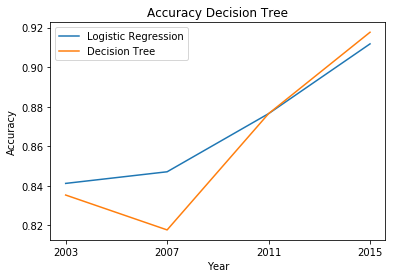

In [151]:
# Create accuracy plot
plot = pd.DataFrame({"Logistic Regression" : a,
                     "Decision Tree" : f}, 
                    index = [2003, 2007, 2011, 2015])
plot.plot(xticks = plot.index)
plt.title("Accuracy Decision Tree")
plt.xlabel("Year")
plt.ylabel("Accuracy")
plt.show()

## KNN

### Looking for the optimal number of neighbours

82.6470588235294
84.70588235294117
86.17647058823529
86.17647058823529
85.29411764705883
85.14705882352942
85.73529411764707
84.70588235294117
84.26470588235293
83.67647058823529
85.14705882352942
83.52941176470588
84.11764705882354
83.38235294117646
84.41176470588235
83.6764705882353
85.29411764705884
84.85294117647058
85.44117647058822
84.55882352941177
85.58823529411764
85.44117647058822
86.02941176470588
85.88235294117649


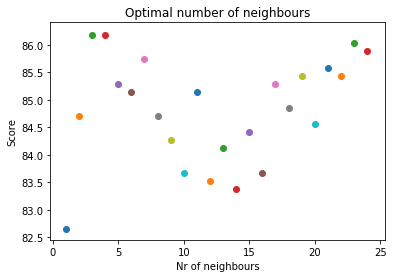

In [139]:
# Searching for the number of the neighbors that returns the best model accuracy
from sklearn.neighbors import KNeighborsClassifier

for i in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=i, p=2, metric='minkowski')
    knn.fit(X_uni, y_dummy)
    results3 = cross_val_score(knn, X_uni, y_dummy, cv=kfold)
    mean=results3.mean()*100
    plt.scatter(i, mean)
    plt.title("Optimal number of neighbours")
    plt.xlabel("Nr of neighbours")
    plt.ylabel("Score")
    print(mean)
plt.show()

### Test accuracy of KNN

In [152]:
# Create x variable
X1 = [df03.iloc[:,[13]],
      df07.iloc[:,[13]],
      df11.iloc[:,[13]],
      df15.iloc[:,[13]]]

# Create y variable 
y1 = [df03[['dummy_zero']].reset_index(drop = True), 
      df07[['dummy_zero']].reset_index(drop = True),
      df11[['dummy_zero']].reset_index(drop = True),
      df15[['dummy_zero']].reset_index(drop = True)]

In [153]:
# Accuracy 
h = []
for i in range(0,3):
    knn = KNeighborsClassifier(n_neighbors=3, p=3, metric='minkowski')
    knn = knn.fit(X1[i], y1[i])
    if i == 0: 
        h.append(accuracy_score(y1[i], tree.predict(X1[i]), normalize=True))
        h.append(accuracy_score(y1[i+1], tree.predict(X1[i+1]), normalize=True))
    else: 
        h.append(accuracy_score(y1[i+1], tree.predict(X1[i+1]), normalize=True))

/Users/joelgysel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


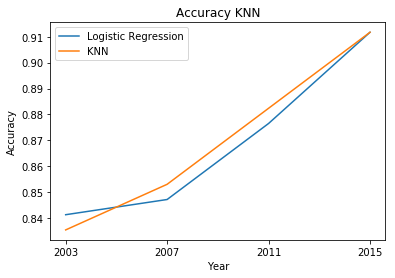

In [154]:
# Create accuracy plot
plot = pd.DataFrame({"Logistic Regression" : a,
                     "KNN" : h}, 
                    index = [2003, 2007, 2011, 2015])
plot.plot(xticks = plot.index)
plt.title("Accuracy KNN")
plt.xlabel("Year")
plt.ylabel("Accuracy")
plt.show()